# Trotter error analysis for the Heisenberg Hamiltonian
Recap of code and estimates for the first and second order Trotter error scaling as a function of the parameters of the system.\
I estimate:
* Single-step Trotter error bounds.
* Trotter error after $r$ steps.

For each bound, I provide estimates for the scaling laws of each contribution to the error.
For the single-step error, I assume a scaling of the form:
$$
\epsilon_\alpha(dt)\leq\mathcal{O}\left(\mathcal{G}^{S_1^\alpha}N^{S_2^\alpha}dt^{S_3^\alpha}\right)\equiv e_\alpha(N, dt, \{g_{ij}, i,j=1,\dots,N, i<j\}),\quad\alpha=1,2 \tag{1}
$$
For the total error, I assume a scaling of the form:
$$
\epsilon_\alpha(T)=r\cdot\epsilon(dt)\leq\mathcal{O}\left(\mathcal{G}^{T_1^\alpha}N^{T_2^\alpha}T^{T_3^\alpha}r^{T_4^\alpha}\right)\equiv E_\alpha(N, T, r, \{g_{ij}, i,j=1,\dots,N, i<j\}),\quad\alpha=1,2 \tag{2}
$$
where $r = T/dt$.

I discuss later why I define stuff like this.

## Error estimate formulas
To provide bounds for the additive Trotter error I use Proposition 9 and 10 in https://journals.aps.org/prx/pdf/10.1103/PhysRevX.11.011020 (Theory of Trotter Error with Commutator Scaling):
* first order: $\varepsilon_1(t)\coloneqq\left\| \mathscr{S}_1(t) - e^{-i t H} \right\| \leq \frac{t^2}{2} \sum_{\gamma_1=1}^{\Gamma}  \left\| \left[ \sum_{\gamma_2 = \gamma_1 + 1}^{\Gamma}H_{\gamma_2}, H_{\gamma_1} \right] \right\|$ 
* second order: $\varepsilon_2(t)\coloneqq\left\| \mathscr{S}_2(t) - e^{-i t H} \right\| \leq \; \frac{t^3}{12} \sum_{\gamma_1=1}^{\Gamma}  \left\| \left[ \sum_{\gamma_3 = \gamma_1 + 1}^{\Gamma}H_{\gamma_3}, \sum_{\gamma_2 = \gamma_1 + 1}^{\Gamma} \left[ H_{\gamma_2}, H_{\gamma_1} \right] \right] \right\| + \frac{t^3}{24} \sum_{\gamma_1=1}^{\Gamma} \left\| \left[ H_{\gamma_1}, \left[ H_{\gamma_1}, \sum_{\gamma_2 = \gamma_1 + 1}^{\Gamma} H_{\gamma_2} \right] \right] \right\|$

The $N$ qubit Heisenberg Hamiltonian, the target Hamiltonian of my simulation, is given below together with its decomposition in analog blocks:
$$
H_\text{Heisenberg}^N = \sum_{\substack{p,q=1\\p<q}}g_{pq}\left(X_pX_q+Y_pY_q+Z_pZ_q\right) \equiv H_{XY}^N+H_{XZ}^N+H_{YZ}^N \tag{3}
$$
where $H_{AB}^N \equiv \sum_{\substack{p,q=1\\p<q}}\frac{g_{pq}}{2}\left(A_pA_q+B_pB_q\right)$.

The structure of the simulation algorithm I specialize these formulas to the $\Gamma=3$ case (see section 4.3 in latex notes):
* first order: $$\varepsilon_1(t)\leq\frac{t^2}{2}\left\{\|[B_N,A_N]\|+\|[C_N,A_N]\|+\|[C_N,B_N]\|\right\} \tag{4}$$
* second order: 
$$
\begin{split}
&\varepsilon_2(t)\leq\frac{t^3}{12}\Bigl\{\|[B_N,[B_N,A_N]]\|+\|[B_N,[C_N,A_N]]\|+\|[C_N,[B_N,A_N]]\|+\|[C_N,[C_N,A_N]]\|+\|[C_N,[C_N,B_N]]\|\Bigr\}+\\
&\qquad\qquad+\frac{t^3}{24}\Bigl\{\|[A_N,[A_N,B_N]]\|+\|[A_N,[A_N,C_N]]\|+\|[B_N,[B_N,C_N]]\|\Bigr\}
\end{split} \tag{5}
$$

where $A_N=-iH_{XY}^{(N)},\quad B_N=-iH_{XZ}^{(N)},\quad C_N=-iH_{YZ}^{(N)}$.

In the following sections, I use these formulas to provide upper bounds for the scaling of the Trotter error.

## Commutator evaluators
I have been developing a series of tools that allow me to compute explicitly the commutators involved in $(4)$ and $(5)$.

I need to implement functions that compute the commutators symbolically, with the additional option of computing the numerical results, given additional informations about the system's parameters.

### Conventions and `gen_Heisenberg_terms.py`.
The first step consists in providing means to represent and compute the terms that appear in each contribution in $(3)$ (I use $A_N,B_N,C_N$ as names because they are the ones actually involved in the commutators, even tough the function computes $H_{XY}^N, H_{XZ}^N, H_{YZ}^N$. But the spectral norm is the same whether we I compute commutators of the first set of objects or the second one because the $i$ factors ampunt to a multiplicative $1$ when taken out of the spectral norms). 

I choose to represent these terms as lists of tuples, where each tuple represents a single term as 
```(scalar coefficient (float), coupling coefficient (string), Pauli string (string))```
The `gen_Heisenberg_terms.py` function then generates $A_N,B_N,C_N$ according to the above definitions.

In [124]:
def gen_Heisenberg_terms(N):
        XY = [] 
        XZ = []   
        YZ = [] 

        for i in range(N):
            for j in range(i + 1, N):
                gate_id = f"g{i+1}{j+1}" 

                xx_term = ["X" if k == i or k == j else "I" for k in range(N)]
                yy_term = ["Y" if k == i or k == j else "I" for k in range(N)]
                zz_term = ["Z" if k == i or k == j else "I" for k in range(N)]

                XY.append((0.5, gate_id, "".join(xx_term)))
                XY.append((0.5, gate_id, "".join(yy_term)))

                XZ.append((0.5, gate_id, "".join(xx_term)))
                XZ.append((0.5, gate_id, "".join(zz_term)))

                YZ.append((0.5, gate_id, "".join(yy_term)))
                YZ.append((0.5, gate_id, "".join(zz_term)))

        return XY, XZ, YZ

A3, B3, C3 = gen_Heisenberg_terms(3)
A3

[(0.5, 'g12', 'XXI'),
 (0.5, 'g12', 'YYI'),
 (0.5, 'g13', 'XIX'),
 (0.5, 'g13', 'YIY'),
 (0.5, 'g23', 'IXX'),
 (0.5, 'g23', 'IYY')]

### Commutators of linear combination of Pauli strings
At this point I want to implement functions that compute the commutators of generic sequences combinations of Pauli strings. I choose not to approach this tasks by computing the commutators via matrix multiplication because I couldn't see how to include symbolic couplings in the scheme.

Because of this, I choose to implement the calculation of Pauli strings commutators by hard coding the rules that govern the commutators between individual Pauli strings.

Consider two Pauli N-strings 
$$
M_1 = P_1\otimes \dots \otimes P_N, \quad M_2 = Q_1\otimes \dots \otimes Q_N
$$
where $P_k,Q_k\in\{\mathbb{I}_k,X_k,Y_k,Z_k\}$. Their commutator reads:
$$
\begin{split}
    & [M_1,M_2] = M_1M_2-M_2M_1 \\
    & \qquad = (P_1Q_1)\otimes \dots \otimes (P_NQ_N)-(Q_1P_1)\otimes \dots \otimes (Q_NP_N)
\end{split}
$$
Here I recall the key multiplication rule of Pauli operators: two Pauli matrices (including the identity) $P,Q$ are always such that
$$
PQ=\pm QP
$$ 
with $+$ when they are equal or one of them is the identity, and $-$ otherwise. I have that:
$$
PQ = (-1)^{N_\text{anticommuting}}QP \tag{6}
$$
Hence, to determine whether the commutator of two arbitrary strings is null I have to count the pairs of single qubit operators that anticommute in a non-trivial way; considering a pair of Pauli operators $P_k$, $Q_k$ at site $k$, $N_\text{anticommuting}$ is increased only if $P_k\neq Q_k$ and both differ from the identity.



In [125]:
pauli_mult_table = {
    ('I', 'I'): (1, 'I'),
    ('I', 'X'): (1, 'X'),
    ('I', 'Y'): (1, 'Y'),
    ('I', 'Z'): (1, 'Z'),
    ('X', 'I'): (1, 'X'),
    ('Y', 'I'): (1, 'Y'),
    ('Z', 'I'): (1, 'Z'),
    ('X', 'X'): (1, 'I'),
    ('Y', 'Y'): (1, 'I'),
    ('Z', 'Z'): (1, 'I'),
    ('Y', 'Z'): (+1j, 'X'),
    ('X', 'Y'): (+1j, 'Z'),
    ('Z', 'X'): (+1j, 'Y'),
    ('Y', 'X'): (-1j, 'Z'),
    ('Z', 'Y'): (-1j, 'X'),
    ('X', 'Z'): (-1j, 'Y'),
    ('0', 'I'): (0, '0'),
    ('0', 'X'): (0, '0'),
    ('0', 'Y'): (0, '0'),
    ('X', '0'): (0, '0'),
    ('I', '0'): (0, '0'),
    ('X', '0'): (0, '0'),
    ('Y', '0'): (0, '0'),
    ('Z', '0'): (0, '0')
}

### How `comm_pstr` works.
The `comm_pstr` function computes the commutator of two generic Pauli strings. The arguments of the function are Pauli strings `pstr1`, `pstr2` given in the format set in the conventions. 

First, I create variables `ps1`, `ps2` for the both individual Pauli strings. Then I create additional variables to keep track of the various bits involved in the commutator:
* `coeff`: numerical coefficient of the resulting Pauli string. Its initial value is given by the product of the numerical coefficients of the input strings.
* `psfinal`: the Pauli string that results from the commutator.
* `acomm_cnt`: number of anticommuting sites, determined as described in the previous section.

Then, I loop over the characters of the Pauli strings to determine how each pair contributes to the coefficient and whether the pair anticommutes. The anticommuting check can only happen after looping over the strings at least once, hence the main loop also determines the Pauli operator that results from the individual pair. This operation is performed using the `pauli_mult_table` dictionary defined above; corresponds to $N_\text{anticommuting}$ of equation $(6)$. 

**Example 1**: $N=3$, $P_1 = X_1X_2 = X\otimes X\otimes I$, $P_2 = Y_2Y_3 = I\otimes Y\otimes Y$. Their commutator is easily found:
$$
\left[P_1,P_2\right] = (XI)\otimes(XY)\otimes(IY)-(IX)\otimes(YX)\otimes(YI) = X\otimes(XY-YX)\otimes Y = X\otimes[X,Y]\otimes Y = 2iX_1Z_2Y_3
$$
&emsp;&emsp;&emsp;&emsp;&emsp;This is the "standard" way to compute this commutator. A slightly different way of getting this result gives a great insight in my way of implementing the commutation rules: using the `pauli_mult_table` &emsp;&emsp;&emsp;&emsp;&emsp;rules
$$
\left[P_1,P_2\right] = X\otimes(XY-YX)\otimes Y = X\otimes(iZ - (-iZ))\otimes Y = 2\cdot\left(X\otimes(iZ)\otimes Y\right) = 2iX_1Z_2Y_3
$$

**Example 2**: $N=5$, $P_1 = X_1X_2X_3X_4 = X\otimes X\otimes X\otimes X\otimes I$, $P_2 = Y_2Y_3Y_4Y_5 = I\otimes Y\otimes Y\otimes Y\otimes Y$.
$$
\begin{split}
& \left[P_1,P_2\right] = (XI)\otimes(XY)\otimes(XY)\otimes(XY)\otimes(IY)-(IX)\otimes(YX)\otimes(YX)\otimes(YX)\otimes(YI) = \\
& \qquad = X\otimes(\underbrace{(XY)}_{iZ}\underbrace{(XY)}_{iZ}\underbrace{(XY)}_{iZ}-\underbrace{(YX)}_{-iZ})\underbrace{(YX)}_{-iZ})\underbrace{(YX)}_{-iZ})\otimes Y \\
& \qquad = X_1\otimes i^3\left(Z_2Z_3Z_4-(-1)^3 Z_2Z_3Z_4\right)\otimes Y_5 \\
& \qquad = i^3 X_1\otimes\left(Z_2Z_3Z_4 + Z_2Z_3Z_4\right)\otimes Y_5 \\
& \qquad = -2i X_1Z_2Z_3Z_4Y_5\\
\end{split}
$$
&emsp;&emsp;&emsp;&emsp;&emsp;Note that the numerical coefficient is $2$ instead of $2^3$, which might be the initial guess since there are $3$ non-trivial pairs.

These examples elucidate the working of the `comm_pstr` function, which essentially replicates the logic of my way of computing the commutators. Note that the $2$ factor is included separately at the end.



In [126]:
def comm_pstr(pstr1, pstr2):
    """
    `comm_pstr(self, pstr1, pstr2)`
    pstr1, pstr2 (tuple): (numeric coefficient, couplings, individual Pauli string)

    comm_pstr function computes the commutator [pstr1, pstr2], keeping track of resulting numeric coefficient and coupling combination.
    return: (numeric coefficient, couplings, individual Pauli string) (tuple)
    """
    ps1 = pstr1[2] # e.g. "IXX"
    ps2 = pstr2[2] # e.g. "YIY"

    coeff = pstr1[0] * pstr2[0]
    psfinal = ""
    acomm_cnt = 0

    for i in range(len(ps1)):
        p1 = ps1[i]
        p2 = ps2[i]

        if p1 != p2 and p1 != 'I' and p2 != 'I': acomm_cnt += 1

        pair = pauli_mult_table[(p1, p2)]
        coeff = coeff * pair[0]
        psfinal += pair[1]

    if acomm_cnt % 2 == 0 or '0' in psfinal:
        return (0, "", '0'*len(ps1))
    
    return (2*coeff, f"({pstr1[1]})({pstr2[1]})", psfinal)

def comm_lincombo(psum1, psum2):
    """
    `comm_lincombo(self, psum1, psum2)`
    psum1, psum2 (list of tuples): [(numeric coefficient 1, couplings 1, individual Pauli string 1), ...]

    comm_lincombo computes the commutator of two sums of Pauli strings, keeping track of numerical coefficients and coupling powers.
    return: [(resulting numeric coefficient 1, resulting couplings 1, resulting individual Pauli string 1), ...] (list of tuples)
    """
    list_comm = []

    for elem1 in psum1:
        for elem2 in psum2:
            res = comm_pstr(elem1, elem2)
            if '0' not in res[2]: list_comm.append((res[0], res[1], res[2]))

    return list_comm

Test the functions by computing the commutators of the above examples.

In [127]:
# Example 1
pstr1 = (1, "g12", "XXI")
pstr2 = (1, "g23", "IYY")

pstr_comm = comm_pstr(pstr1, pstr2)
pstr_comm

(2j, '(g12)(g23)', 'XZY')

In [128]:
# Example 2
pstr1 = (1, "(g12)(g34)", "XXXXI")
pstr2 = (1, "(g23)(g45)", "IYYYY")

pstr_comm = comm_pstr(pstr1, pstr2)
pstr_comm

(-2j, '((g12)(g34))((g23)(g45))', 'XZZZY')

I briefly comment how `comm_lincombo` works. It takes as arguments two lists of tuples, representing linear combinations of Pauli strings, and computes their commutator using the linearity of the commutator in both entries with respect to summation and scalar multiplication. Given linear combination of Pauli strings $P$, $Q$ defined by
$$
P = \sum_{m=1}^{l_P} a_mP_m, \quad Q = \sum_{n=1}^{l_Q} b_nQ_n 
$$
where $a_m$, $b_n$ include both numerical coefficient and couplings. Their commutator is given by
$$
[P,Q] = \left[\sum_{m=1}^{l_P} a_mP_m,\sum_{n=1}^{l_Q} b_nQ_n\right] = \sum_{m=1}^{l_P}\sum_{n=1}^{l_Q}[a_mP_m,b_nQ_n]
$$
Each term is then handled using `comm_pstr`, and the result is stored in `list_comm` to be returned.

### Test: 3 qubit commutators
I have previously computed the 3 qubit commutators relevant to the computation of the Trotter error by hand. These provide a benchmark to test my functions.

In the following I recall the analytical results:
$$
\begin{split}
    & [A_3,B_3] = \frac{i}{2}\Biggl\{X_1Y_2Z_3\left(g_{12}g_{13}-g_{12}g_{23}-g_{13}g_{23}\right) +X_1Z_2Y_3\left(g_{12}g_{13}-g_{12}g_{23}-g_{13}g_{23}\right)+\\
    & \qquad+Y_1X_2Z_3\left(-g_{12}g_{13}+g_{12}g_{23}-g_{13}g_{23}\right)+Y_1Z_2X_3\left(-g_{12}g_{13}-g_{12}g_{23}+g_{13}g_{23}\right)+\\
    & \qquad+Z_1X_2Y_3\left(-g_{12}g_{13}+g_{12}g_{23}-g_{13}g_{23}\right)+Z_1Y_2X_3\left(-g_{12}g_{13}-g_{12}g_{23}+g_{13}g_{23}\right)\Biggr\}
\end{split}
$$

$$
\begin{split}
    & [A_3,C_3] = \frac{i}{2}\Biggl\{X_1Y_2Z_3\left(g_{12}g_{13}-g_{12}g_{23}+g_{13}g_{23}\right) +X_1Z_2Y_3\left(g_{12}g_{13}+g_{12}g_{23}-g_{13}g_{23}\right)+\\
    & \qquad+Y_1X_2Z_3\left(-g_{12}g_{13}+g_{12}g_{23}+g_{13}g_{23}\right)+Y_1Z_2X_3\left(-g_{12}g_{13}+g_{12}g_{23}+g_{13}g_{23}\right)+\\
    & \qquad+Z_1X_2Y_3\left(g_{12}g_{13}+g_{12}g_{23}-g_{13}g_{23}\right)+Z_1Y_2X_3\left(g_{12}g_{13}-g_{12}g_{23}+g_{13}g_{23}\right)\Biggr\}
\end{split}
$$

$$
\begin{split}
    & [B_3,C_3] = \frac{i}{2}\Biggl\{X_1Y_2Z_3\left(-g_{12}g_{13}-g_{12}g_{23}+g_{13}g_{23}\right) +X_1Z_2Y_3\left(-g_{12}g_{13}+g_{12}g_{23}-g_{13}g_{23}\right)+\\
    & \qquad+Y_1X_2Z_3\left(-g_{12}g_{13}-g_{12}g_{23}+g_{13}g_{23}\right)+Y_1Z_2X_3\left(-g_{12}g_{13}+g_{12}g_{23}-g_{13}g_{23}\right)+\\
    & \qquad+Z_1X_2Y_3\left(g_{12}g_{13}-g_{12}g_{23}-g_{13}g_{23}\right)+Z_1Y_2X_3\left(g_{12}g_{13}-g_{12}g_{23}-g_{13}g_{23}\right)\Biggr\}\\
\end{split}
$$

In [129]:
A3B3 = comm_lincombo(A3,B3)
A3C3 = comm_lincombo(A3,C3)
B3C3 = comm_lincombo(B3,C3)

A3B3

[(-0.5j, '(g12)(g13)', 'YXZ'),
 (-0.5j, '(g12)(g23)', 'XYZ'),
 (-0.5j, '(g12)(g13)', 'ZYX'),
 (0.5j, '(g12)(g13)', 'XYZ'),
 (-0.5j, '(g12)(g23)', 'YZX'),
 (0.5j, '(g12)(g23)', 'YXZ'),
 (-0.5j, '(g13)(g12)', 'YZX'),
 (-0.5j, '(g13)(g23)', 'XZY'),
 (-0.5j, '(g13)(g12)', 'ZXY'),
 (0.5j, '(g13)(g12)', 'XZY'),
 (-0.5j, '(g13)(g23)', 'YXZ'),
 (0.5j, '(g13)(g23)', 'YZX'),
 (-0.5j, '(g23)(g12)', 'ZYX'),
 (-0.5j, '(g23)(g13)', 'ZXY'),
 (-0.5j, '(g23)(g12)', 'XZY'),
 (0.5j, '(g23)(g12)', 'ZXY'),
 (-0.5j, '(g23)(g13)', 'XYZ'),
 (0.5j, '(g23)(g13)', 'ZYX')]

I implement the function `group_by_pauli_string` that collects terms with the same Pauli string. The output is a dictionary that associates each individual Pauli string present in the output to a list of lists, each of which represents a contribution to that string.

In [130]:
def group_by_pauli_string(comm, N):

    def is_coeff_equal(str1, str2):
        pair1 = str1.split(")(")        
        pair2 = str2.split(")(")
        pair1 = [p.strip('(').strip(')').strip('g') for p in pair1]
        pair2 = [p.strip('(').strip(')').strip('g') for p in pair2]

        return sorted(pair1) == sorted(pair2)
        
    list_terms = {}
    for term in comm:
        if term[2] != "0"*N:
            if term[2] not in list_terms:
                list_terms[term[2]] = [[term[0], term[1]]]
            else:
                cnt_not = 0 
                for i, elem in enumerate(list_terms[term[2]]):
                    if is_coeff_equal(term[1], elem[1]):
                        list_terms[term[2]][i][0] += elem[0] # refactor coefficient
                    else:
                        cnt_not +=1 
                if cnt_not == len(list_terms[term[2]]): list_terms[term[2]].append([term[0], term[1]]) # TODO can it be changed to ([term[0], term[1])?

    return list_terms

In [131]:
grouped_A3B3 = group_by_pauli_string(A3B3, 3)
grouped_A3B3

{'YXZ': [[-0.5j, '(g12)(g13)'], [0.5j, '(g12)(g23)'], [-0.5j, '(g13)(g23)']],
 'XYZ': [[-0.5j, '(g12)(g23)'], [0.5j, '(g12)(g13)'], [-0.5j, '(g23)(g13)']],
 'ZYX': [[-0.5j, '(g12)(g13)'], [-0.5j, '(g23)(g12)'], [0.5j, '(g23)(g13)']],
 'YZX': [[-0.5j, '(g12)(g23)'], [-0.5j, '(g13)(g12)'], [0.5j, '(g13)(g23)']],
 'XZY': [[-0.5j, '(g13)(g23)'], [0.5j, '(g13)(g12)'], [-0.5j, '(g23)(g12)']],
 'ZXY': [[-0.5j, '(g13)(g12)'], [-0.5j, '(g23)(g13)'], [0.5j, '(g23)(g12)']]}

This completes the discussion of the commutator evaluators.

I will now describe how I use the methods discussed in this section to extract informations about the behaviour of the Trotter error scalings of my simulation.

## Single-step error
To evaluate the upper bound for the single-step error of the simulation I need to compute expression $(4)$ for fixed $t=dt$ and fixed $N$.

### First order Trotter
Now I work on the numerical computation of Trotter error bound formulas. I'm able to compute and simplify each contribution present in $(4)$, but at this stage I have only symbolic expressions available.

I start by preparing the symbolic expressions for the commutators for $N=3,\dots,8$.

In [132]:
max_N = 8

A3, B3, C3 = gen_Heisenberg_terms(3)
A4, B4, C4 = gen_Heisenberg_terms(4)
A5, B5, C5 = gen_Heisenberg_terms(5)
A6, B6, C6 = gen_Heisenberg_terms(6)
A7, B7, C7 = gen_Heisenberg_terms(7)
A8, B8, C8 = gen_Heisenberg_terms(8)

A3B3 = comm_lincombo(A3, B3)
A3C3 = comm_lincombo(A3, C3)
B3C3 = comm_lincombo(B3, C3)

A4B4 = comm_lincombo(A4, B4)
A4C4 = comm_lincombo(A4, C4)
B4C4 = comm_lincombo(B4, C4)

A5B5 = comm_lincombo(A5, B5)
A5C5 = comm_lincombo(A5, C5)
B5C5 = comm_lincombo(B5, C5)

A6B6 = comm_lincombo(A6, B6)
A6C6 = comm_lincombo(A6, C6)
B6C6 = comm_lincombo(B6, C6)

A7B7 = comm_lincombo(A7, B7)
A7C7 = comm_lincombo(A7, C7)
B7C7 = comm_lincombo(B7, C7)

A8B8 = comm_lincombo(A8, B8)
A8C8 = comm_lincombo(A8, C8)
B8C8 = comm_lincombo(B8, C8)

terms_A3B3 = group_by_pauli_string(A3B3, N=3)
terms_A3C3 = group_by_pauli_string(A3C3, N=3)
terms_B3C3 = group_by_pauli_string(B3C3, N=3)

terms_A4B4 = group_by_pauli_string(A4B4, N=4)
terms_A4C4 = group_by_pauli_string(A4C4, N=4)
terms_B4C4 = group_by_pauli_string(B4C4, N=4)

terms_A5B5 = group_by_pauli_string(A5B5, N=5)
terms_A5C5 = group_by_pauli_string(A5C5, N=5)
terms_B5C5 = group_by_pauli_string(B5C5, N=5)

terms_A6B6 = group_by_pauli_string(A6B6, N=6)
terms_A6C6 = group_by_pauli_string(A6C6, N=6)
terms_B6C6 = group_by_pauli_string(B6C6, N=6)

terms_A7B7 = group_by_pauli_string(A7B7, N=7)
terms_A7C7 = group_by_pauli_string(A7C7, N=7)
terms_B7C7 = group_by_pauli_string(B7C7, N=7)

terms_A8B8 = group_by_pauli_string(A8B8, N=8)
terms_A8C8 = group_by_pauli_string(A8C8, N=8)
terms_B8C8 = group_by_pauli_string(B8C8, N=8)

I want to understand how I should numerically sum the various contributions in each commutator to provide a bound for the first order error.
$$
\begin{split}
& \epsilon_1(dt)\leq\frac{dt^2}{2}\left\{\|[B_N,A_N]\|+\|[C_N,A_N]\|+\|[C_N,B_N]\|\right\} \\
& \qquad = \frac{dt^2}{2}\left\{\left\|\sum_{k\in\mathcal{D}_1^N}\mathcal{G}_kP_k\right\|+\left\|\sum_{k\in\mathcal{D}_2^N}\mathcal{G}_kP_k\right\|+\left\|\sum_{k\in\mathcal{D}_3^N}\mathcal{G}_kP_k\right\|\right\} \\
& \qquad \leq \frac{dt^2}{2}\left\{\sum_{k\in\mathcal{D}_1^N}|\mathcal{G}_k|\cancel{\|P_k\|}+\sum_{k\in\mathcal{D}_2^N}|\mathcal{G}_k|\cancel{\|P_k\|}+\sum_{k\in\mathcal{D}_3^N}|\mathcal{G}_k|\cancel{\|P_k\|}\right\} \\
& \qquad = \frac{dt^2}{2}\left\{\sum_{k\in\mathcal{D}_1^N}|\mathcal{G}_k|+\sum_{k\in\mathcal{D}_2^N}|\mathcal{G}_k|+\sum_{k\in\mathcal{D}_3^N}|\mathcal{G}_k|\right\} \tag{7}\\
\end{split}
$$

In the second step I represented the contributions to each term reflecting the output of the `group_by_pauli_string` function: $\mathcal{D}_1^N$, $\mathcal{D}_2^N$, $\mathcal{D}_3^N$ represent the keys of the dictionary, to each of which a value $\mathcal{G}_k$, given by some linear combination of powers of coefficients, is associated.

In the third step I used that the spectral norm of a Pauli string is $1$.

Now it's clear how to compute the first order Trotter error for fixed $N$, $dt$ and given a set of values for the coupling coefficients. The `fixed_t_commsum_T1` function does it.

In [133]:
def fixed_t_commsum_T1(terms, couplings, t): 
    """
    terms (list of dicts): [{"XYZ": [[-0.5j, "(g12)(g23)"], ...], ...}, {"XYZ": [[0.5j, "(g12)(g13)"], ...], ...}]
    couplings (dict): {"g12": 0.1, "g13": 0.2, ...}
    t (float): time length of simulation
    order (int): order of Trotter formula

    return: value of first order Trotter error for a given set of couplings and time  
    """

    def eval_couplings(coeff_str, coupl_dict):
        split_str = coeff_str.split(")(")
        split_str = [p.strip(')').strip('(') for p in split_str]

        prod = 1
        for term in split_str:
            prod *= coupl_dict[term]
            
        return prod
    
    err_vl = 0

    for term_dict in terms:
        for _, terms in term_dict.items():
            coeff = 0
            for term in terms:
                # if term[1] != '': coeff += float(str(term[0]).strip('j')) * eval_couplings(term[1], couplings)
                if term[1] != '': coeff += abs(term[0]) * eval_couplings(term[1], couplings)

            err_vl += abs(coeff)

    err_vl = 0.5 * err_vl * t ** 2

    return err_vl

This function is designed to take as argument the dictionaries associated to the terms in $(4)$. The corresponding error value is then computed according to the logic of equation $(7)$.

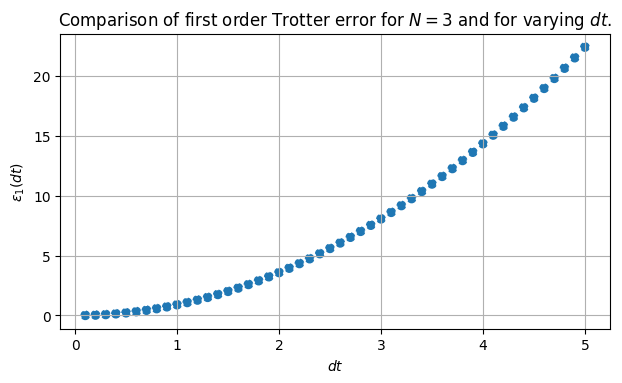

In [169]:
import numpy as np
import matplotlib.pyplot as plt

def create_coupling_dict(N, distribution="constant", interval=(0.05, 0.95)):
    """
    dim (int): number of qubits in the system.
    distribution (str) (default: "constant"): distribution of couplings (if specified)
    interval (tuple) (default: (0.05, 0.95)): interval in which coupling values are generated
    """
    dic = {}
    
    if distribution == "costant":
        for i in range(N):
            for j in range(i+1, N):
                dic[f"g{i+1}{j+1}"] = 0.1
    elif distribution == "uniform":
        for i in range(N):
            for j in range(i+1, N):
                dic[f"g{i+1}{j+1}"] = np.random.uniform(interval[0], interval[1])
    else:
        # TODO: implement narrow cone of forward peaked neutrinos distributions (see https://arxiv.org/pdf/2207.03189)
        raise Exception(f"Couplings of type \"{distribution}\" is not allowed")
    return dic

couplings = create_coupling_dict(max_N, "uniform")

dt_list = np.arange(1, 51) * 0.1
error_dt_N3 = []

for dt in dt_list:
    error_dt_N3.append(fixed_t_commsum_T1([terms_A3B3, terms_A3C3, terms_B3C3], couplings, dt))

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(16 / 2.54, 10 / 2.54)

ax.scatter(dt_list, error_dt_N3, linestyle="--")

ax.set_title (r"Comparison of first order Trotter error for $N=3$ and for varying $dt$.")
ax.set_xlabel(r"$dt$")
ax.set_ylabel(r"$\varepsilon_1(dt)$")

# legend = ax.legend(loc=2, frameon=True, borderaxespad=0.8, fontsize=6)
# legend.get_frame().set_facecolor('white')
# legend.get_frame().set_alpha(1.0)
# legend.get_frame().set_boxstyle("Square")

plt.grid()
plt.tight_layout()
plt.show()

### $N=3$ comparison
I have derived analitically expression $(7)$ for $N=3$. For the sake of testing my numerical routines, in the following code I compute the same expression.

$$
\begin{split}
    & [B_3,A_3]+[C_3,A_3]+[C_3,B_3] = \frac{i}{2}\Bigl\{X_1Y_2Z_3\left(g_{12}g_{13}-3g_{12}g_{23}+g_{13}g_{23}\right)+X_1Z_2Y_3\left(g_{12}g_{13}+g_{12}g_{23}-3g_{13}g_{23}\right)+\\
    & \qquad+Y_1X_2Z_3\left(-3g_{12}g_{13}+g_{12}g_{23}+g_{13}g_{23}\right)+Y_1Z_2X_3\left(-3g_{12}g_{13}+g_{12}g_{23}+g_{13}g_{23}\right)+\\
    & \qquad+Z_1X_2Y_3\left(g_{12}g_{13}+g_{12}g_{23}-3g_{13}g_{23}\right)+Z_1Y_2X_3\left(g_{12}g_{13}-3g_{12}g_{23}+g_{13}g_{23}\right)\Bigr\}
\end{split}
$$

In [135]:
def merge_terms_dicts(dict_list):
    def canonicalize(term):
        factors = term.replace(")(", " ").replace("(", "").replace(")", "").split()
        factors = sorted(factors)
        return "(" + ")(".join(factors) + ")"

    result = {}

    for d in dict_list:
        for key, pairs in d.items():
            if key not in result:
                result[key] = {}

            for coeff, term in pairs:
                norm_term = canonicalize(term)
                if norm_term in result[key]:
                    result[key][norm_term] += coeff
                else:
                    result[key][norm_term] = coeff

    for key in result:
        result[key] = [[coeff, term] for term, coeff in result[key].items() if coeff != 0]

    return result

merged3 = merge_terms_dicts([terms_A3B3, terms_A3C3, terms_B3C3])
merged3

{'YXZ': [[-1.5j, '(g12)(g13)'], [0.5j, '(g12)(g23)'], [0.5j, '(g13)(g23)']],
 'XYZ': [[-1.5j, '(g12)(g23)'], [0.5j, '(g12)(g13)'], [0.5j, '(g13)(g23)']],
 'ZYX': [[0.5j, '(g12)(g13)'], [-1.5j, '(g12)(g23)'], [0.5j, '(g13)(g23)']],
 'YZX': [[0.5j, '(g12)(g23)'], [-1.5j, '(g12)(g13)'], [0.5j, '(g13)(g23)']],
 'XZY': [[-1.5j, '(g13)(g23)'], [0.5j, '(g12)(g13)'], [0.5j, '(g12)(g23)']],
 'ZXY': [[0.5j, '(g12)(g13)'], [-1.5j, '(g13)(g23)'], [0.5j, '(g12)(g23)']]}

The results are indeed equal.

## Decomposition of first order Trotter error
Recall expression $(1)$. I assume that the function $e_1$ decomposes as
$$
e_1(N, dt, \{g_{ij}, i,j=1,\dots,N, i<j\}) = n_1(N)\cdot\tau_1(dt)\cdot G_1(\{g_{ij}\})\qquad \text{ILLEGAL (maybe)}
$$
As anticipated in $(1)$, I can make the additional assumption that each function is a power law. 

The goal of this section is to determine the first order Trotter error scaling by studying each component of the error separately.

Consider expression $(4)$ for arbitrary N. I can massage it in a form that justifies my assumption about the structure of the $e_1$ function. 
$$
\begin{split}
& \frac{t^2}{2}\left\{\|[B_N,A_N]\|+\|[C_N,A_N]\|+\|[C_N,B_N]\|\right\} = \frac{t^2}{2}\left\{\left\|[H_{XY}^N,H_{XZ}^N]\right\|+\left\|[H_{XY}^N,H_{YZ}^N]\right\|+\left\|[H_{XZ}^N,H_{YZ}^N]\right\|\right\} \\
& \qquad = \frac{t^2}{8}\Biggl\{\left\|\sum_{\substack{p,q=1\\ p<q}}^N\sum_{\substack{m,n=1\\ m<n}}^N g_{pq}g_{mn}\left([X_pX_q,Z_mZ_n]+[Z_pZ_q,X_mX_n]+[Y_pY_q,Z_mZ_n]\right)\right\|+\left\|\sum_{\substack{p,q=1\\ p<q}}^N\sum_{\substack{m,n=1\\ m<n}}^N g_{pq}g_{mn}\left([X_pX_q,Z_mZ_n]+[Z_pZ_q,X_mX_n]+[Y_pY_q,Z_mZ_n]\right)\right\|+\\
& \qquad + \left\|\sum_{\substack{p,q=1\\ p<q}}^N\sum_{\substack{m,n=1\\ m<n}}^N g_{pq}g_{mn}\left([X_pX_q,Z_mZ_n]+[Z_pZ_q,X_mX_n]+[Y_pY_q,Z_mZ_n]\right)\right\|\Biggr\}\\
\end{split}
$$
Now call $\Pi=max_{p,q,m,n}\left(g_{pq}g_{mn}\right)$, 
$$
\dots
$$

## Numerical analysis of single-step first order Trotter error scaling
I fit the various components of the error factorization. 

### Fit of $dt$ scaling.
Analyze time scaling of single step error moving in the space of the other parameters. I fit the error function fixing $N$ and the set of coupling constants $\{g_{ij}\}$. I then vary the values of the latter to explore the scaling behaviour in different scenarios. The fit function is given by:
$$
\begin{split}
& e_1(\tilde{N}, dt, \{\tilde{g}_{ij}\}) = C_3\cdot (dt)^{\mathcal{S}_3^\alpha} \\
& \implies \log(e_1) = C_3 + S_{3}^\alpha\cdot \log(dt) \\
\end{split}
$$
where $C_3$ represents the contribution due to the number of qubits in the system and the coupling values.


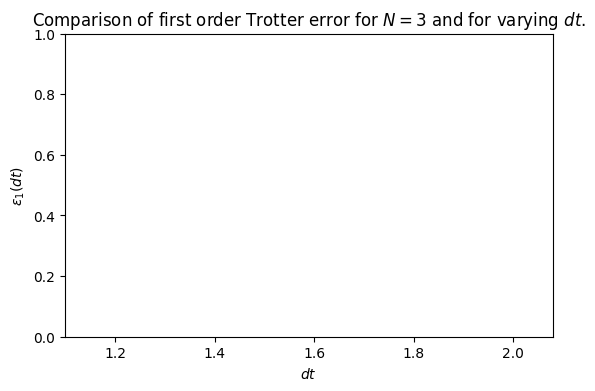

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors  
from matplotlib.offsetbox import AnchoredText
from iminuit import Minuit
from iminuit.cost import LeastSquares  

def color_gradient(start, end, n):
    """Generate n hex colors from start to end."""
    start_rgb = np.array(mcolors.to_rgb(start))
    end_rgb = np.array(mcolors.to_rgb(end))
    return [mcolors.to_hex(start_rgb + (end_rgb - start_rgb) * i/(n-1)) for i in range(n)]

values_N = np.arange(3,9)
sim = 20

def line(x, C, alpha):
    return C + alpha*x

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(16 / 2.54, 10 / 2.54)

dt_list = np.arange(1,10) * 0.1

colors = color_gradient("#ff0000", "#0000ff", len(dt_list))
colors_line = color_gradient("#ff0000dd", "#0000ffc7", len(dt_list))

err_vls = []
for dt in dt_list:
    couplings = create_coupling_dict(max_N, "uniform")
    vls = []
    vls.append(fixed_t_commsum_T1([terms_A3B3, terms_A3C3, terms_B3C3], couplings, dt))
    vls.append(fixed_t_commsum_T1([terms_A4B4, terms_A4C4, terms_B4C4], couplings, dt)) 
    vls.append(fixed_t_commsum_T1([terms_A5B5, terms_A5C5, terms_B5C5], couplings, dt)) 
    vls.append(fixed_t_commsum_T1([terms_A6B6, terms_A6C6, terms_B6C6], couplings, dt)) 
    vls.append(fixed_t_commsum_T1([terms_A7B7, terms_A7C7, terms_B7C7], couplings, dt)) 
    vls.append(fixed_t_commsum_T1([terms_A8B8, terms_A8C8, terms_B8C8], couplings, dt)) 
    err_vls.append(vls)

log_N_vls = np.log(values_N)
log_err_vls = [np.log(vls) for vls in err_vls]
m_objects = []

for i, log_vls in enumerate(log_err_vls): 
    ls_obj = LeastSquares(log_N_vls, log_vls, 0*log_N_vls + 0.001, line)
    m_obj = Minuit(ls_obj, C=1, alpha=1)
    m_obj.migrad()
    m_obj.hesse()
    m_objects.append(m_obj)

for i, log_vls in enumerate(log_err_vls): 
    

ax.set_title (r"Comparison of first order Trotter error for $N=3$ and for varying $dt$.")
ax.set_xlabel(r"$dt$")
ax.set_ylabel(r"$\varepsilon_1(dt)$")
ax.set_xlim(np.min(log_N_vls), np.max(log_N_vls))

plt.show()
